In [ ]:
"""
input:
    - authorid_date_sentiment.parquet
    - date_based_covid_data_ATV_and_unemployment.parquet
output:
    - histplot_of_2020-11-01.svg
    - user_differences_with_standard_error.svg
    - monthly_user_differences_with_standard_error.svg
    - positive_ratio_point_plot_before_after_monthly_mean.svg
    - atv_and_socio_economics_separated.pdf
"""

In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy.stats import sem
import matplotlib.pyplot as plt
from statannot import add_stat_annotation

from src.scripts.tools import Tools

In [5]:
tools = Tools()

def find_next_date(date, month=True):
    if month:
        greater_and_equal_to = date + pd.DateOffset(months=1)
    else:
        greater_and_equal_to = date + pd.DateOffset(days=1)

    return greater_and_equal_to

def find_users_and_generate_new_dfs(date, next_date):
    df_before_date = authorid_date_sentiment_count[authorid_date_sentiment_count['created_at'] < date]
    df_after_next_date = authorid_date_sentiment_count[authorid_date_sentiment_count['created_at'] >= next_date]

    df_before_date['before_after'] = ['Before'] * df_before_date.shape[0]
    df_after_next_date['before_after'] = ['After'] * df_after_next_date.shape[0]

    users_before = df_before_date['author_id'].values
    users_after = df_after_next_date['author_id'].values

    common_users = set(users_before).intersection(users_after)

    return common_users, pd.concat([df_before_date, df_after_next_date], axis=0).reset_index(drop=True)

def draw_point_plot(df):
    fig, ax = plt.subplots(figsize=(5, 5))

    for x in ['Before', 'After']:
        y = df[df['x'] == x]['y'].values
        mean, error = np.mean(y), sem(y)
        ax.plot([x]*2, [mean-error, mean+error], c='blue', zorder=0)

    group = df.groupby('x').agg({'y':'mean'}).reset_index()

    ax.scatter(x=group['x'].values, y=group['y'].values, c='blue', zorder=5)
    return fig, ax

def creating_df(date, month=True):
    next_date = find_next_date(date, month=month)

    unique_users, filtered_df = find_users_and_generate_new_dfs(date, next_date)
    average = filtered_df[filtered_df['author_id'].isin(unique_users)]
    average = average.groupby(['author_id', 'before_after', 'sentiment_label']).agg({'count':'sum'}).reset_index()
    average = average.pivot_table(index=['author_id', 'before_after'], columns='sentiment_label',
                                  values='count', dropna=False).fillna(0).reset_index()
    average['positive_ratio'] = average[1].values / (average[1].values + average[0].values)
    average = average[['author_id', 'before_after', 'positive_ratio']].rename_axis(None, axis=1)
    return average

def create_diff_df(date, month=True):
    avrg = creating_df(date, month=month)
    avrg = avrg.pivot_table(index='author_id', values='positive_ratio', columns='before_after').reset_index()
    avrg['diff'] = avrg['After'].values - avrg['Before'].values
    avrg = avrg.drop(columns=['Before', 'After'])
    avrg['date'] = [date] * avrg.shape[0]
    return avrg

In [9]:
supp_figures_path = "/figures/experimental/supp_figures"
main_figures_path = "/figures/experimental/main_figures"
dataframes_path = "/data/processed/dataframes"

# Plotting figures

In [7]:
authorid_date_sentiment = pd.read_parquet(f"{dataframes_path}/authorid_date_sentiment.parquet")
authorid_date_sentiment['created_at'] = pd.to_datetime(authorid_date_sentiment['created_at'].values)

authorid_date_sentiment_count = authorid_date_sentiment.value_counts().reset_index(name='count')



### For 1st of November 2020

In [ ]:
df = creating_df(pd.to_datetime('2020-11-01'), month=False)

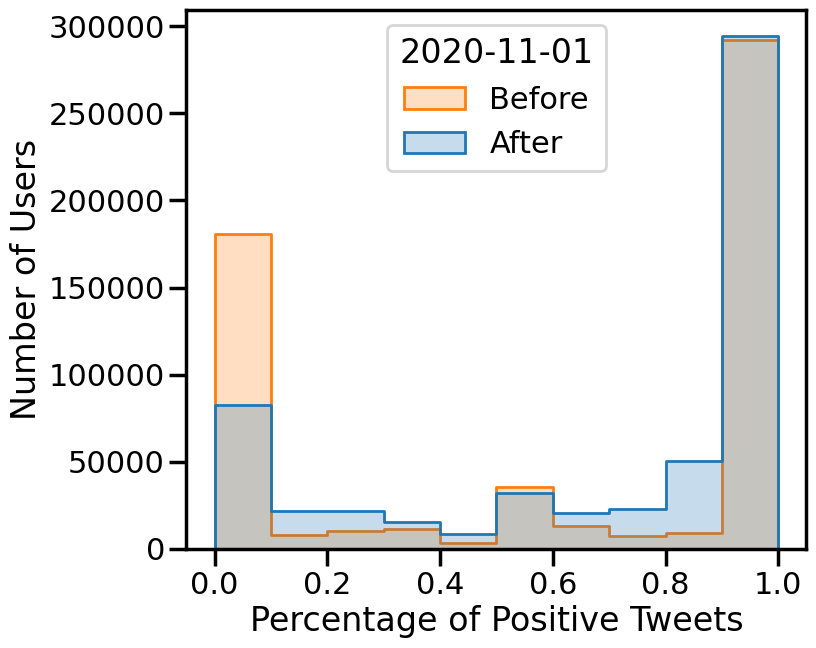

In [10]:
sns.set_context('poster', font_scale=1)

fig, ax = plt.subplots(figsize=(8, 7))
sns.histplot(data=df, x="positive_ratio", hue='before_after', bins=10, element='step', ax=ax)
ax.set_ylabel('Number of Users')
ax.set_xlabel('Percentage of Positive Tweets')

ax.legend(title='2020-11-01', loc='upper center', labels=['Before', 'After'])

plt.savefig(f'{main_figures_path}/histplot_of_2020-11-01.svg', bbox_inches='tight')

### Daily

In [51]:
unique_dates = np.sort(authorid_date_sentiment_count['created_at'].unique())[1:-1]

diff_dfs = []
for date in tqdm(pd.to_datetime(unique_dates)):
    diff_dfs.append(create_diff_df(date, month=False))

In [52]:
def mean_and_error(dfs, column_name='diff', error_type='standard_error'):
    """
    error_type: either 'quantile' or 'standard_error'
                default: 'standard_error'
    """
    means, errors = [], []

    for df in tqdm(dfs):
        values = df[column_name].values

        mean = values.mean()
        means.append(mean)
        if error_type == 'quantile':
            errors.append([np.quantile(values, 0.05), 
                           np.quantile(values, 0.95)])
        
        else:
            standard_error = sem(values)
            errors.append([mean - standard_error,
                        mean + standard_error])
        
    return means, errors

def smooth_values(means, errors, rolling_step):
    smoothed_mean = pd.Series(means).rolling(rolling_step, win_type='gaussian', min_periods=1).mean(std=3)
    smoothed_errors0 = pd.Series([i[0] for i in errors]).rolling(rolling_step, win_type='gaussian', min_periods=1).mean(std=3)
    smoothed_errors1 = pd.Series([i[1] for i in errors]).rolling(rolling_step, win_type='gaussian', min_periods=1).mean(std=3)

    return smoothed_mean, smoothed_errors0, smoothed_errors1

In [53]:
means, errors = mean_and_error(diff_dfs)
smoothed_mean, smoothed_errors0, smoothed_errors1 = smooth_values(means, errors, rolling_step=15)

100%|██████████| 729/729 [00:01<00:00, 421.26it/s]


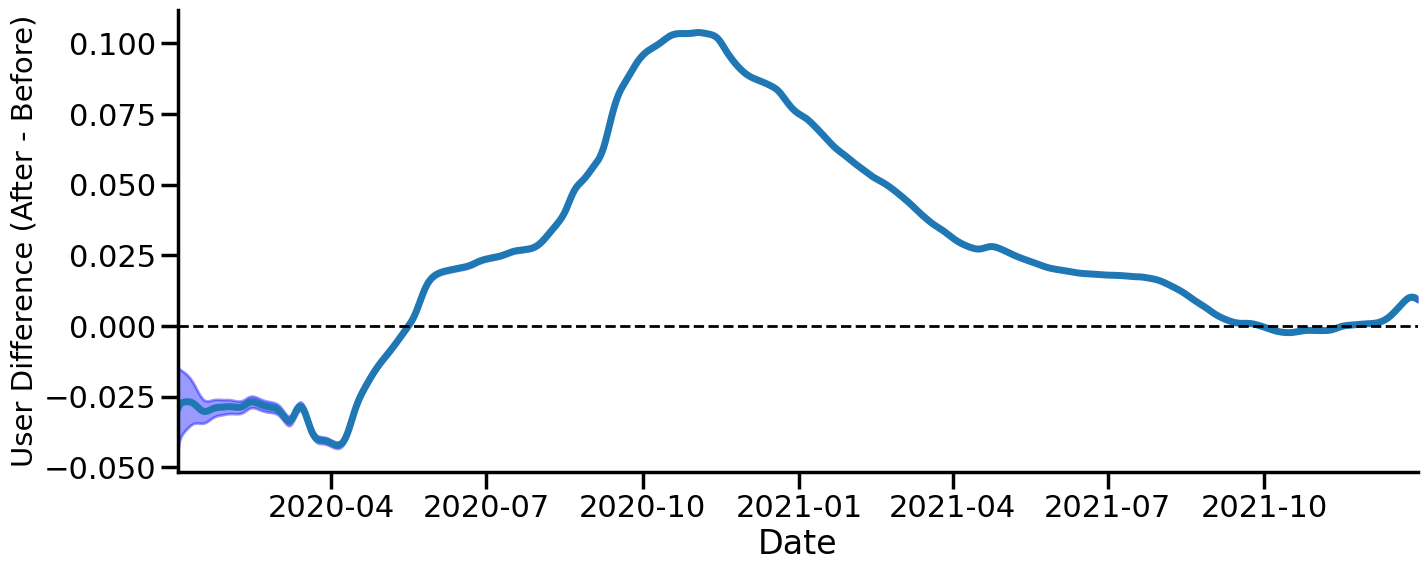

In [16]:
sns.set_context('poster', 1)

plt.figure(figsize=(16, 6))
plt.plot(unique_dates, smoothed_mean, linewidth=5)
plt.fill_between(unique_dates, smoothed_errors0, smoothed_errors1, color='blue',
                 alpha=0.4)
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)
plt.xlabel('Date')
plt.ylabel('User Difference (After - Before)', fontdict=dict(size=21))
plt.margins(x=0)
sns.despine()

plt.savefig(f'{main_figures_path}/user_differences_with_standard_error.svg', bbox_inches='tight')

### Monthly

In [17]:
unique_months = set([i[:7] for i in authorid_date_sentiment_count['created_at'].unique().astype(str)])
unique_months = pd.to_datetime(list(unique_months))
unique_months = np.sort(unique_months)[1:-1]

In [ ]:
diff_dfs = []

for date in tqdm(pd.to_datetime(unique_months)):
    diff_dfs.append(create_diff_df(date, month=True))

In [19]:
means, errors = mean_and_error(diff_dfs)
smoothed_mean, smoothed_errors0, smoothed_errors1 = smooth_values(means, errors, rolling_step=1)

100%|██████████| 22/22 [00:00<00:00, 369.17it/s]


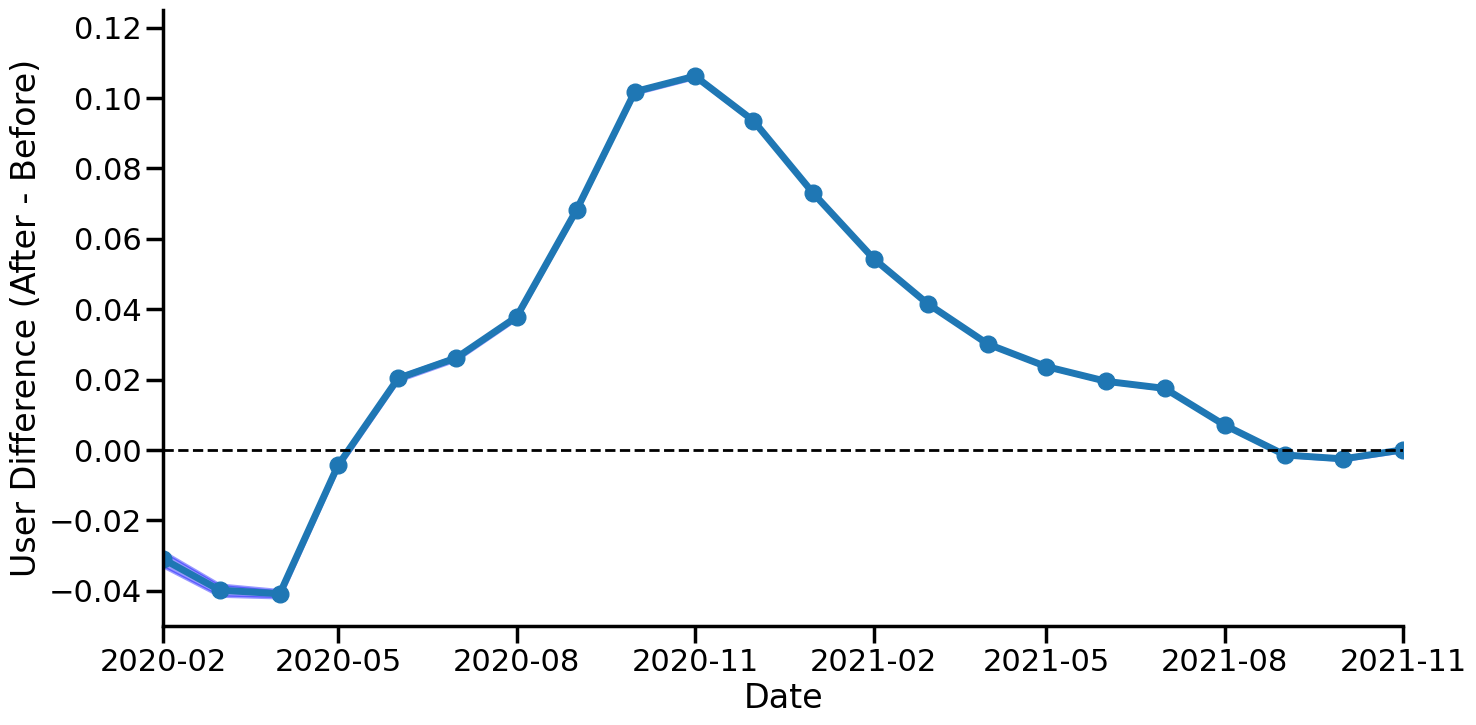

In [21]:
sns.reset_orig()
sns.set_context('poster')

plt.figure(figsize=(16, 8))
plt.plot(unique_months, smoothed_mean, 'o-', linewidth=5)
plt.fill_between(unique_months, smoothed_errors0, smoothed_errors1, color='blue',
                 alpha=0.4)
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)
plt.xticks([unique_months[idx] for idx in range(len(unique_months)) if idx % 3 == 0],
           [unique_months.astype('str')[idx][:7] for idx in range(len(unique_months)) if idx % 3 == 0])
plt.margins(x=0)
plt.ylim(-0.050, 0.125)
plt.xlabel('Date')
plt.ylabel('User Difference (After - Before)')
sns.despine()

plt.savefig(f'{supp_figures_path}/monthly_user_differences_with_standard_error.svg', bbox_inches='tight')

## Wilcoxon test with Bonferroni Correction

In [ ]:
unique_dates = np.unique([str(i)[:7] + '-01' for i in authorid_date_sentiment_count['created_at'].unique()])[1:-1].tolist()
dfs = [creating_df(pd.to_datetime(i), month=True) for i in unique_dates]

In [32]:
for idx in range(len(dfs)):
    dfs[idx]['date'] = [unique_dates[idx][:7]] * dfs[idx].shape[0]

dfs_combined = pd.concat(dfs, axis=0).reset_index(drop=True)

In [33]:
combined_mean_dfs = pd.concat([dfs[idx].groupby(['date', 'before_after']).agg({"positive_ratio":'mean'}).reset_index() for idx in range(len(dfs))], axis=0)

<ipython-input-25-47204fc29cc2>:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  fig2 = sns.pointplot(data=combined_mean_dfs, y='positive_ratio', x='date', hue='before_after', ci=68, join=False, dodge=True, ax=ax)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
2020-11_After v.s. 2020-11_Before: Wilcoxon test (paired samples) with Bonferroni correction, P_val=0.000e+00 stat=1.893e+10
Using zero_method  wilcox
2020-12_After v.s. 2020-12_Before: Wilcoxon test (paired samples) with Bonferroni correction, P_val=0.000e+00 stat=2.635e+10
Using zero_method  wilcox
2021-01_After v.s. 2021-01_Before: Wilcoxon test (paired samples) with Bonferroni correction, P_val=0.000e+00 stat=4.408e+10
Using zero_method  wilcox
2021-02_After v.s. 2021-02_Before: Wilcoxon test (paired samples) with Bonferroni correction, P_val=0.000e+00 stat=5.893e+10
Using zero_method  wilcox
2021-03_After v.s. 2021-03_Before: Wilcoxon test (paired samples) with Bonferroni correction, P_val=0.000e+00 stat=6.519e+10
Using zero_method  wilcox
2021-04_After v.s. 2021-04_Before: Wilcoxon test (paire

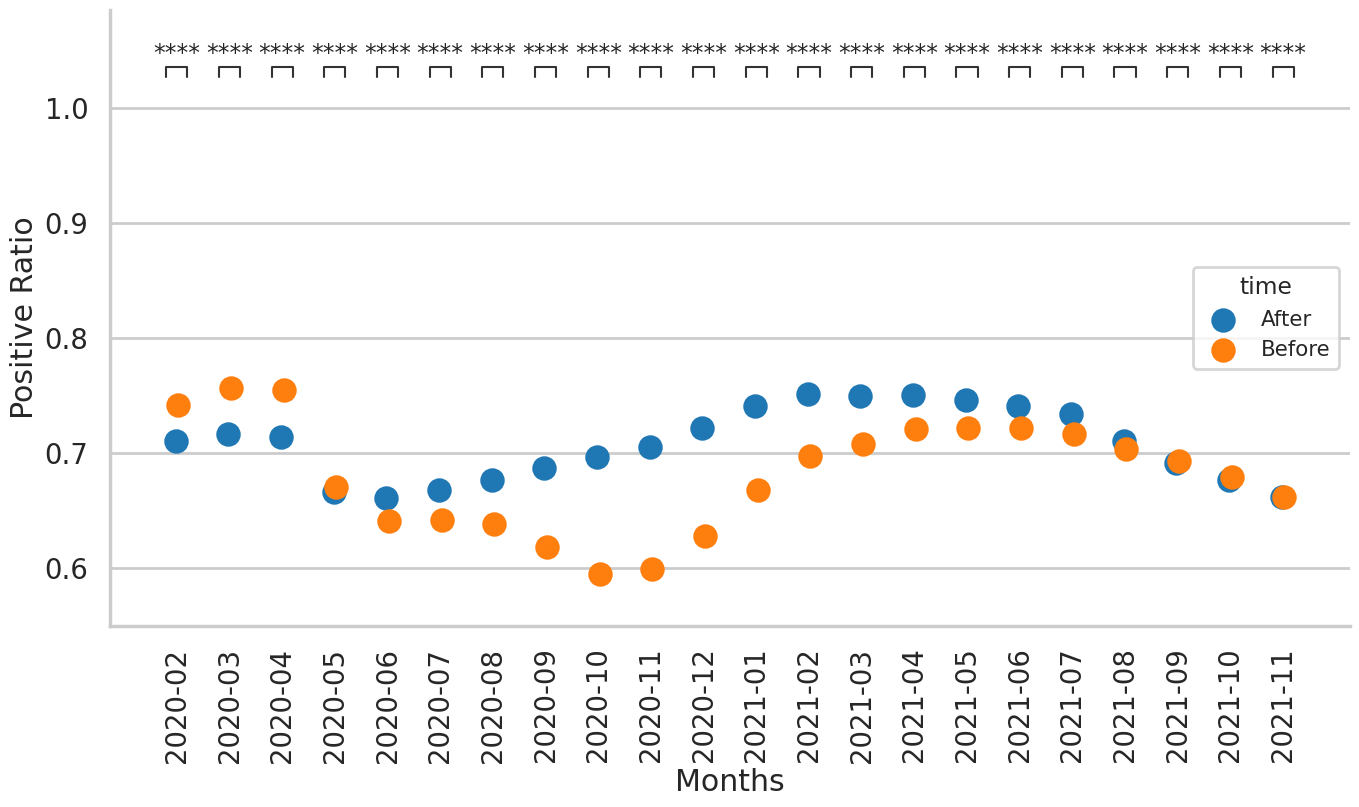

In [25]:
sns.set_context('poster', 0.9)
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(16, 8))
fig2 = sns.pointplot(data=combined_mean_dfs, y='positive_ratio', x='date', hue='before_after', ci=68, join=False, dodge=True, ax=ax)

plt.ylim(0.55, 1)
plt.xlabel('Months')
plt.ylabel('Positive Ratio')
plt.xticks(rotation=90)

sns.set_context('poster', 0.7)
add_stat_annotation(ax, data=dfs_combined,  x='date', y='positive_ratio', hue='before_after',
                    box_pairs=[((date[:7], "Before"), (date[:7], "After")) for date in unique_dates],
                    test='Wilcoxon', text_format='star', loc='inside', verbose=2)
plt.legend(title='time', loc='center right')
sns.despine()
plt.savefig(f"{supp_figures_path}/positive_ratio_point_plot_before_after_monthly_mean.svg", bbox_inches='tight')

## New Cases, Unemployment, ATV Score, Vaccination Perc., User Difference

In [26]:
covid_data_atv_unemployment = pd.read_parquet(f"{dataframes_path}/date_based_covid_data_ATV_and_unemployment.parquet")
covid_data_atv_unemployment['date'] = pd.to_datetime(covid_data_atv_unemployment['date'])

In [27]:
tools.smooth_data(covid_data_atv_unemployment, 1, ['new_cases', 'unemployment', 'odd_ratios'])

In [ ]:
unique_dates = np.sort(authorid_date_sentiment_count['created_at'].unique())[1:-1]

means, errors = mean_and_error(diff_dfs)
smoothed_mean, smoothed_errors0, smoothed_errors1 = smooth_values(means, errors, rolling_step=15)

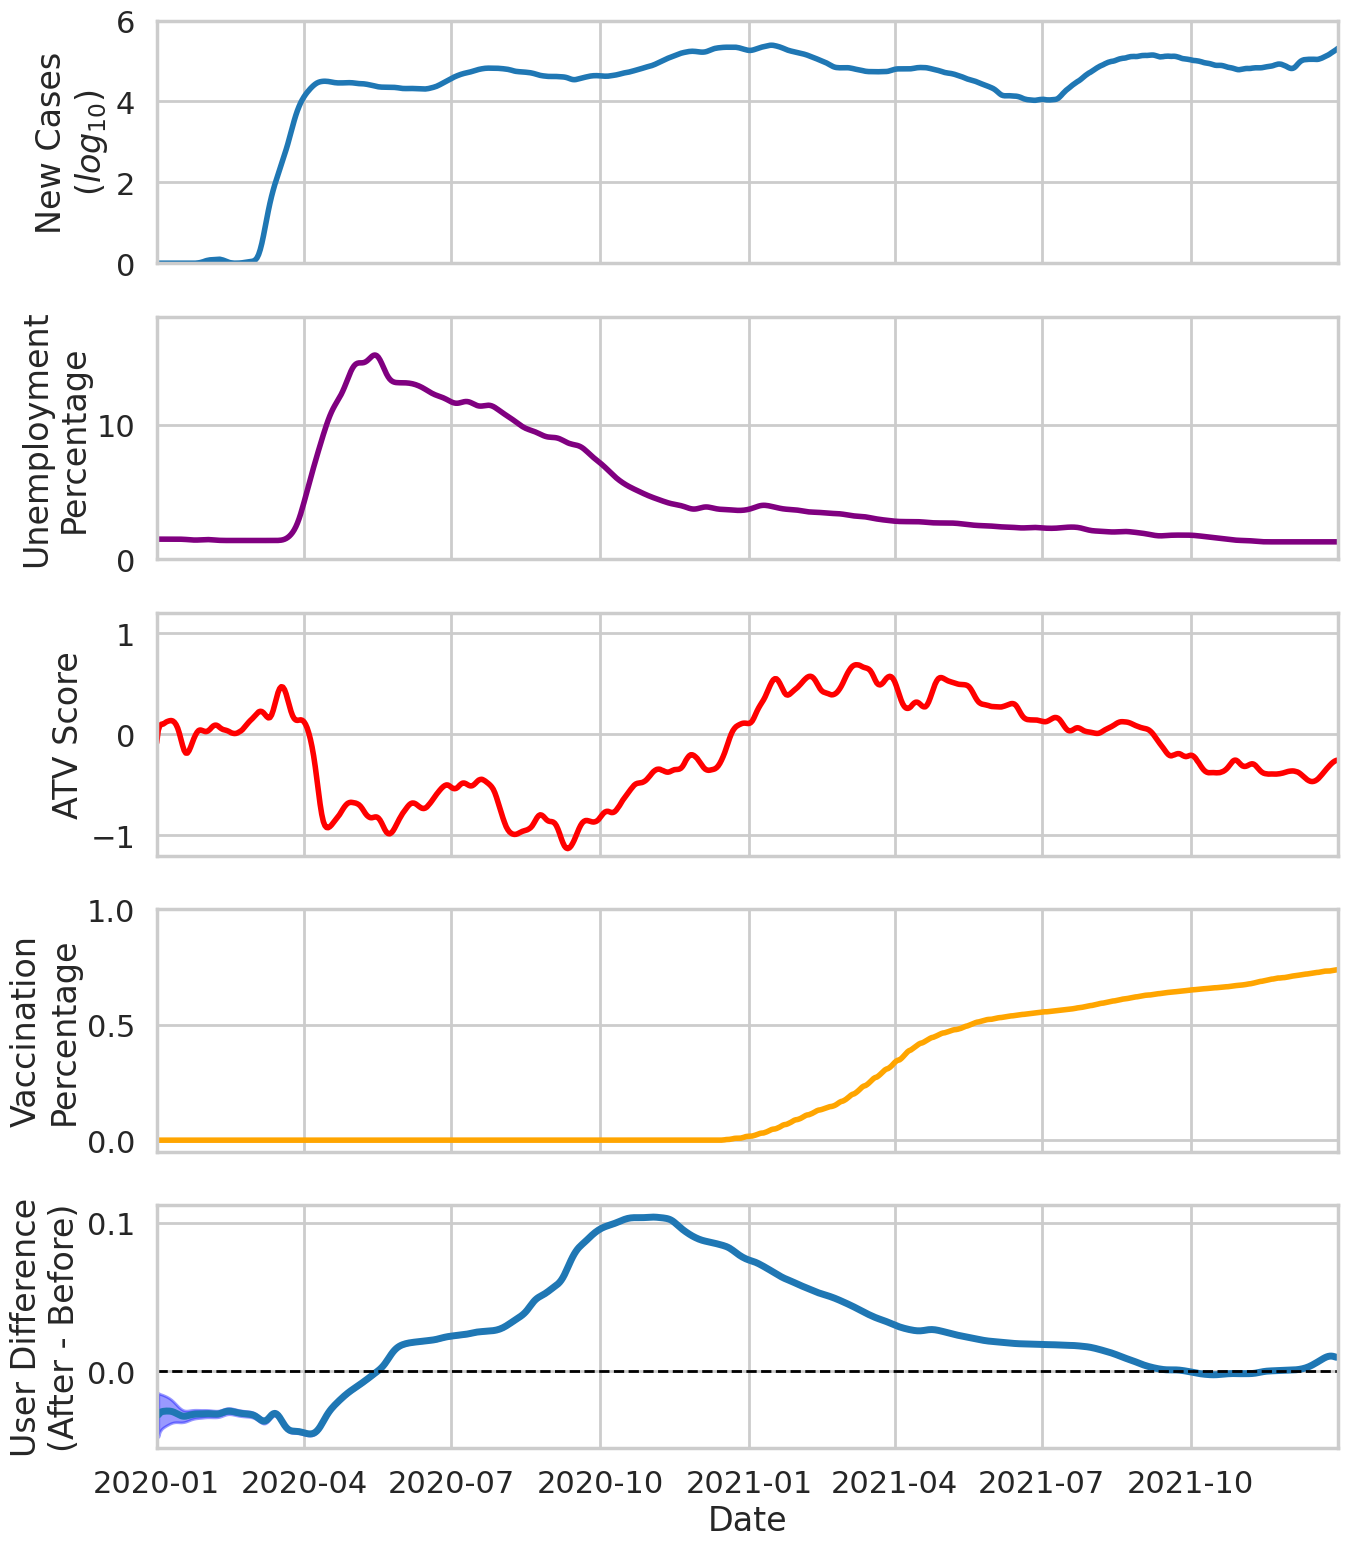

In [54]:
sns.set_context('poster')

fig, axs = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(14, 16))
sns.lineplot(data=covid_data_atv_unemployment, x="date", y='new_cases', linewidth = 4, ax=axs[0])
sns.lineplot(data=covid_data_atv_unemployment, x="date", y='unemployment', linewidth = 4, ax=axs[1], c='purple')
sns.lineplot(data=covid_data_atv_unemployment, x="date", y='odd_ratios', linewidth = 4, ax=axs[2], c='r')
sns.lineplot(data=covid_data_atv_unemployment, x="date", y='people_vaccinated_per_hundred', linewidth = 4, ax=axs[3], c='orange')

axs[4].plot(unique_dates, smoothed_mean, linewidth=5)
axs[4].fill_between(unique_dates, smoothed_errors0, smoothed_errors1, color='blue',
                 alpha=0.4)
axs[4].axhline(y=0, color='black', linestyle='--', linewidth=2)

axs[0].set_ylim([0, 6])
axs[1].set_ylim([0, 18])
axs[2].set_ylim([-1.2, 1.2])
axs[3].set_ylim([-0.05, 1])

axs[0].set_ylabel('New Cases\n$(log_{10})$')
axs[1].set_ylabel('Unemployment\nPercentage')
axs[2].set_ylabel('ATV Score')
axs[3].set_ylabel('Vaccination\nPercentage')
axs[4].set_ylabel('User Difference\n(After - Before)')

plt.xlabel('Date')
plt.margins(x=0)
fig.tight_layout()
fig.savefig(f'{supp_figures_path}/atv_and_socio_economics_separated.pdf')
plt.show()